In [0]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import spacy
import scipy.io
import gc
from sklearn.preprocessing import LabelEncoder
import pickle
import json
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Reshape
from tensorflow.keras import Input
#from keras.layers.recurrent import LSTM
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.layers.merge import Concatenate
from tensorflow.keras.models import model_from_json, Model
from tensorflow.keras.utils import plot_model
from collections import defaultdict
import operator
from tensorflow.python.keras.utils import np_utils, generic_utils
#from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from tensorflow.keras.models import load_model
from tqdm import tqdm
import cv2
%matplotlib inline
#%tensorflow_version 1.x

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer,one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import LSTM, BatchNormalization,concatenate,Flatten,Embedding,Dense,Dropout,MaxPooling2D,Reshape,CuDNNLSTM,SpatialDropout1D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Model,Input
from tensorflow.python.keras.layers.convolutional import Conv2D,Conv1D
from tensorflow.keras.initializers import he_uniform,he_normal
import tensorflow.keras.backend as k
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from time import time
from tensorflow.keras.regularizers import l1,l2,l1_l2
from scipy.sparse import hstack
from tensorflow.python.keras.callbacks import TensorBoard
import tensorflow.keras
import pickle

In [0]:
from google.colab import files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/'My Drive'/v2_OpenEnded_mscoco_train2014_questions.json .
!cp drive/'My Drive'/v2_mscoco_train2014_annotations.json .

In [6]:
cd drive/My Drive

/content/drive/My Drive


In [0]:
from os import listdir
image_dir = 'train2014'
images= listdir(image_dir)

In [0]:
que = json.load(open('v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
ans = json.load(open('v2_mscoco_train2014_annotations.json', 'r'))

In [15]:
print(len(images))

82833


In [16]:
len(ans['annotations'])

443757

In [17]:
len(que['questions'])

443757

In [18]:
que['questions'][0]

{'image_id': 458752,
 'question': 'What is this photo taken looking through?',
 'question_id': 458752000}

In [19]:
ans['annotations'][0]['image_id']

458752

In [20]:
subtype='train2014'
data=[]
imdir='%s/COCO_%s_%012d.jpg'
for i in tqdm(range(len(ans['annotations']))):
    answ=ans['annotations'][i]['multiple_choice_answer']
    que_id=ans['annotations'][i]['question_id']
    im_path=imdir%(subtype,subtype,ans['annotations'][i]['image_id'])
    ques=que['questions'][i]['question']
    data.append({'que_id':que_id,'im_path':im_path,'ques':ques,'answ':answ})

100%|██████████| 443757/443757 [00:00<00:00, 463145.07it/s]


In [77]:
data[0]

{'answ': 'net',
 'im_path': 'train2014/COCO_train2014_000000458752.jpg',
 'que_id': 458752000,
 'ques': 'What is this photo taken looking through?'}

In [0]:
total_data=pd.DataFrame(data)

In [23]:
total_data.head()

,que_id,im_path,ques,answ
0,458752000,train2014/COCO_train2014_000000458752.jpg,What is this photo taken looking through?,net
1,458752001,train2014/COCO_train2014_000000458752.jpg,What position is this man playing?,pitcher
2,458752002,train2014/COCO_train2014_000000458752.jpg,What color is the players shirt?,orange
3,458752003,train2014/COCO_train2014_000000458752.jpg,Is this man a professional baseball player?,yes
4,262146000,train2014/COCO_train2014_000000262146.jpg,What color is the snow?,white


In [0]:
#preprocessing

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
preprocessed_questions = []
for question in tqdm(total_data['ques'].values):
    que = decontracted(question) 
    preprocessed_questions.append(que.lower().strip())

100%|██████████| 443757/443757 [00:03<00:00, 118571.69it/s]


In [0]:
total_data['ques']=preprocessed_questions

In [27]:
total_data.head()

,que_id,im_path,ques,answ
0,458752000,train2014/COCO_train2014_000000458752.jpg,what is this photo taken looking through?,net
1,458752001,train2014/COCO_train2014_000000458752.jpg,what position is this man playing?,pitcher
2,458752002,train2014/COCO_train2014_000000458752.jpg,what color is the players shirt?,orange
3,458752003,train2014/COCO_train2014_000000458752.jpg,is this man a professional baseball player?,yes
4,262146000,train2014/COCO_train2014_000000262146.jpg,what color is the snow?,white


In [0]:
total_data=total_data.reset_index(drop=True)

In [30]:
total_data.shape

(443757, 4)

In [0]:
a=pd.DataFrame(total_data['answ'].value_counts()[:1000])

In [0]:
ind=list(a.index)

In [33]:
len(ind)

1000

In [34]:
top_data=pd.DataFrame()
for i in tqdm(ind):
    top_data1=total_data[total_data.answ == i]
    top_data=pd.concat([top_data,top_data1],ignore_index=True)

100%|██████████| 1000/1000 [01:59<00:00,  8.34it/s]


In [35]:
top_data.shape

(388158, 4)

In [0]:
top_data=top_data.sample(frac=1).reset_index(drop=True)

In [37]:
top_data.head(2)

,que_id,im_path,ques,answ
0,315092001,train2014/COCO_train2014_000000315092.jpg,what color is the back of the clock?,black
1,318953000,train2014/COCO_train2014_000000318953.jpg,what does this man have on his face?,glasses


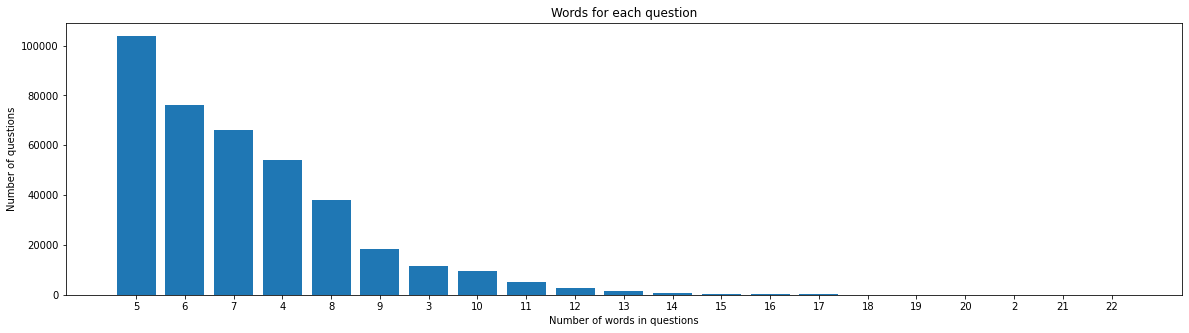

In [0]:
word_count = top_data['ques'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of questions')
plt.xlabel('Number of words in questions')
plt.title('Words for each question')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

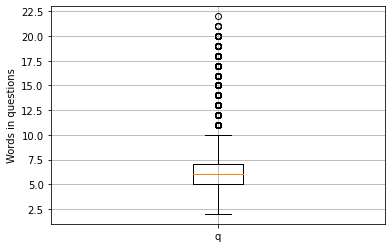

In [0]:
que_word_count = top_data['ques'].str.split().apply(len)
plt.boxplot(que_word_count)
plt.xticks([1],'questions')
plt.ylabel('Words in questions')
plt.grid()
plt.show()

Text(0.5, 1.02, 'Different types of question')

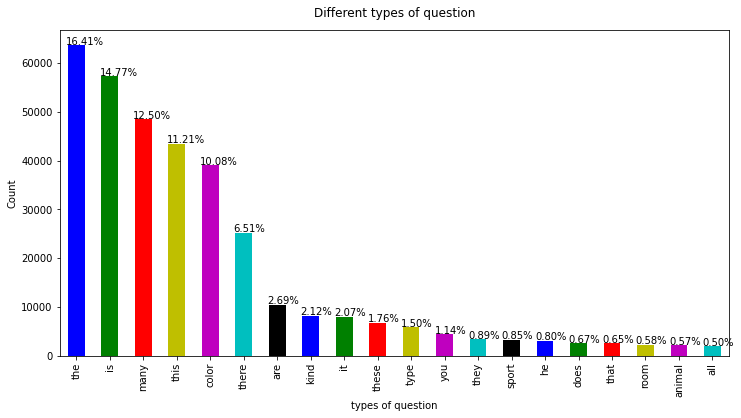

In [0]:
total=len(top_data)
ax=top_data['ques'].str.split().str[1].value_counts()[0:20].plot(kind='bar',color=['b','g','r','y','m','c','k'],figsize=(12,6))
for p in ax.patches:
        ax.annotate('{:.2f}%'.format(100*p.get_height()/total), (p.get_x()-0.05, p.get_height()+100))
plt.xlabel("types of question")
plt.ylabel("Count")
plt.title("Different types of question",y=1.02)

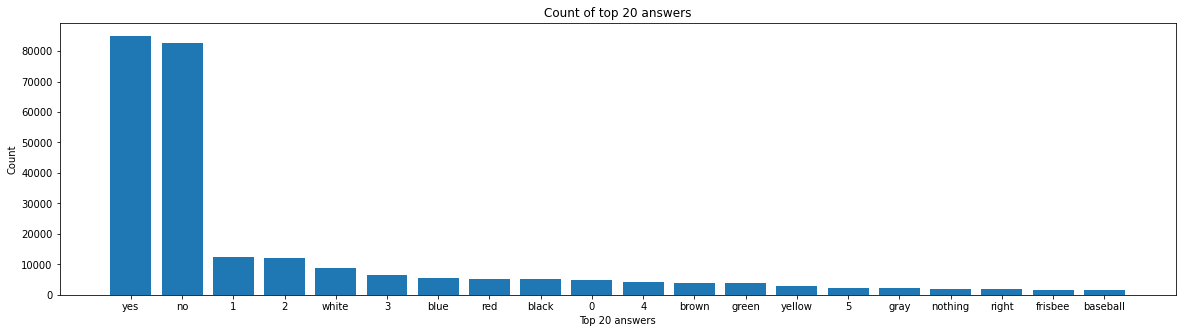

In [0]:
word_count = top_data['answ'].value_counts()[0:20]
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Count')
plt.xlabel('Top 20 answers')
plt.title('Count of top 20 answers')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [0]:
cnt1= top_data[top_data['answ']=='yes']['answ'].count()+top_data[top_data['answ']=='no']['answ'].count()
cnt2= len(top_data)-cnt1
print("Total no of binary('yes'/no) answers:",cnt1)
print("% of binary answers                 :",np.round(cnt1/len(top_data)*100,2))
print("Total no of multiple answers        :",cnt2)
print("% of multiple answers               :",np.round(cnt2/len(top_data)*100,2))

Total no of binary('yes'/no) answers: 167494
% of binary answers                 : 43.15
Total no of multiple answers        : 220664
% of multiple answers               : 56.85


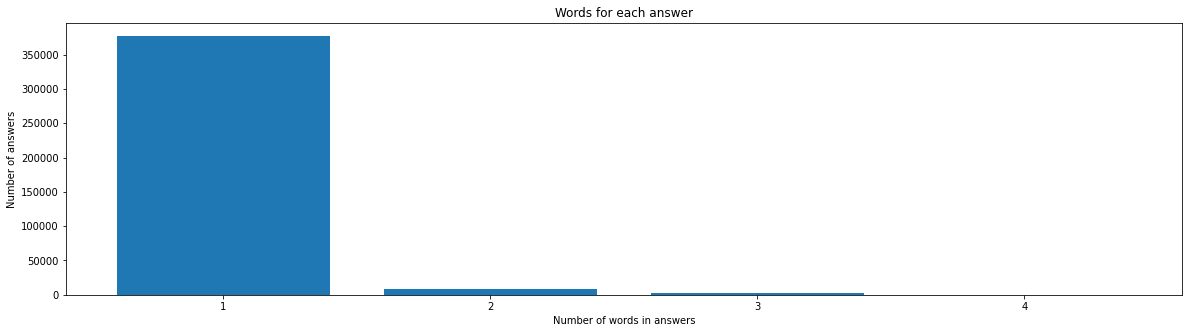

In [0]:
word_count = top_data['answ'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1],reverse=True))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of answers')
plt.xlabel('Number of words in answers')
plt.title('Words for each answer')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [0]:
#top_data=top_data.sample(frac=0.8).reset_index(drop=True)

In [0]:
y = top_data['answ']
top_data.drop(['answ'],axis=1,inplace=True)

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(top_data,y,test_size=0.3,stratify=y,random_state=42)

In [0]:
imtrdf=pd.DataFrame(x_train['im_path'])

In [0]:
imtedf=pd.DataFrame(x_test['im_path'])

In [0]:
#!pip uninstall keras-preprocessing

In [0]:
#pip install git+https://github.com/keras-team/keras-preprocessing.git

  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-h4v7yyfp
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-h4v7yyfp
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.0-cp36-none-any.whl size=42210 sha256=64ed462bedf3cf2f08aecaafb07e4200d053909117c7a62efa1adf68f12126fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-5di6opuj/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


In [0]:
from keras_preprocessing.image import ImageDataGenerator

In [0]:
datagen=ImageDataGenerator(rescale=1./255.)

In [0]:
train_generator=datagen.flow_from_dataframe(
dataframe=imtrdf,
directory=None,
x_col="im_path",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 271710 validated image filenames.


In [0]:
train_generator.next

<bound method Iterator.next of <keras_preprocessing.image.dataframe_iterator.DataFrameIterator object at 0x7f17a285c358>>

In [0]:
sample_training_images= next(train_generator)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

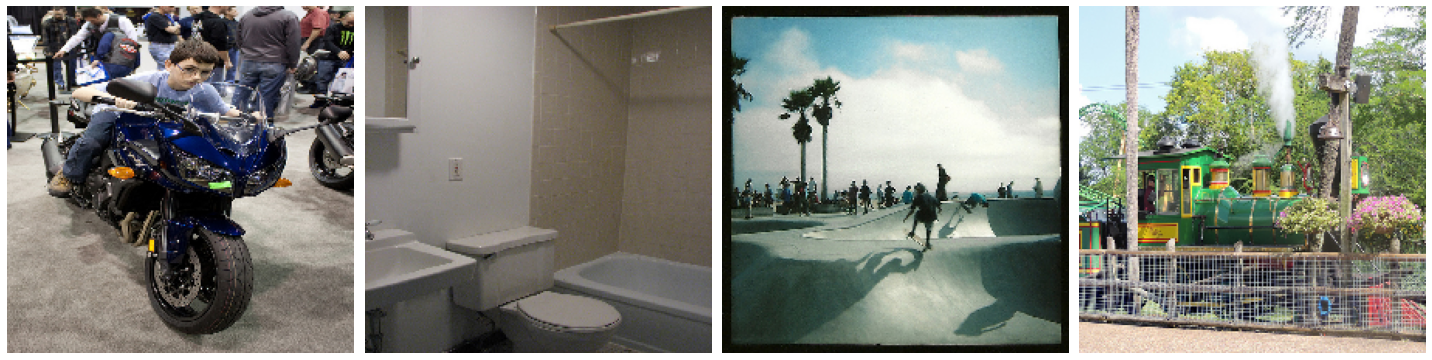

In [0]:
plotImages(sample_training_images[:4])

In [0]:
sample_training_images.shape

(32, 224, 224, 3)

In [0]:
test_generator=datagen.flow_from_dataframe(
dataframe=imtedf,
directory=None,
x_col="im_path",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 116448 validated image filenames.


In [0]:
tok = Tokenizer()
tok.fit_on_texts(x_train['ques'])
vocab_size = len(tok.word_index) + 1
print('Total unique words in the x_train',vocab_size)
encoded_train = tok.texts_to_sequences(x_train['ques'])
encoded_test = tok.texts_to_sequences(x_test['ques'])

Total unique words in the x_train 11575


In [0]:
max_length = 24
X_train = pad_sequences(encoded_train, maxlen=max_length)  #padding zeros at the begining of each review to make max len as 200
X_test = pad_sequences(encoded_test, maxlen=max_length)
print(X_train.shape)
print(X_train[0])

(271710, 24)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0   28   29  331    5   79   66  641    1 5116]


In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
    
# for train
embedding_matrix_train = np.zeros((vocab_size, 300))
for word, i in tok.word_index.items():
    if word in glove_words:
        embedding_vector = model[word]
        embedding_matrix_train[i] = embedding_vector

In [0]:
print("embedding matrix shape",embedding_matrix_train.shape)

embedding matrix shape (11575, 300)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [0]:
from tensorflow.keras.applications.vgg16 import VGG16
vggmodel=VGG16(weights='imagenet',include_top=True)
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
for layers in (vggmodel.layers)[:19]:
    print(layers)
    layers.trainable=False

In [0]:
vggmodel.layers.pop()

In [0]:
vggmodel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
from tensorflow.python.keras.layers import Dense

In [0]:

image_model=Dense(1024,activation='relu')(vggmodel.layers[-1].output)
model2=Model(inputs=vggmodel.inputs,outputs=image_model)
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
inputall.pop()

<tf.Tensor 'ques_input_6:0' shape=(None, 24) dtype=float32>

In [0]:
inputss = []
concat = []
inputall=vggmodel.inputs

In [0]:
inputall

[<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'ques_input_4:0' shape=(None, 24) dtype=float32>,
 <tf.Tensor 'ques_input_5:0' shape=(None, 24) dtype=float32>]

In [0]:
#model=Sequential()
#model.add(Embedding(vocab_size1, 300, weights=[embedding_matrix_train], input_length=max_length,trainable=False))
#model.add(LSTM(512,return_sequences=True))
#model.add(LSTM(512,recurrent_dropout=0.2,return_sequences=True))
#model.summary()

In [0]:
#from tensorflow.python.keras.layers import LSTM
ques_input = Input(shape=(max_length,), name = "ques_input")
# max_length = 150 ---->max length of sentence
inputss.append(ques_input)
inputall.append(ques_input)
e1 =Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=max_length,trainable=False)(ques_input)
l1= LSTM(512,kernel_initializer='glorot_normal',recurrent_dropout=0.5,kernel_regularizer=l2(0.001),return_sequences=True)(e1)
l2= LSTM(512,kernel_initializer='glorot_normal',recurrent_dropout=0.5,kernel_regularizer=l2(0.001),return_sequences=True)(l1)
#l1= LeakyReLU(alpha = 0.3)(l1)
#f1= Flatten()(l2)
question_model=Dense(1024,activation='relu')(l2)
#x= Dense(1024, activation='relu',kernel_initializer="he_normal",kernel_regularizer=l2(0.001))(f1)
concat.append(f1)
model1 = Model(inputs=inputss, outputs=question_model)
model1.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ques_input (InputLayer)      [(None, 24)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 24, 300)           3472500   
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 512)           1665024   
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 512)           2099200   
_________________________________________________________________
dense_9 (Dense)              (None, 24, 1024)          525312    
Total params: 7,762,036
Trainable params: 4,289,536
Non-trainable params: 3,472,500
_________________________________________________________________


In [0]:
from tensorflow.keras.layers import multiply

In [0]:
type(model1.layers[-1].output)

tensorflow.python.framework.ops.Tensor

In [0]:
input_model=multiply([model1.layers[-1].output,model2.layers[-1].output])

In [0]:
d1=Dense(1000,activation='relu')(input_model)
d1 = Dropout(0.5)(d1)
d1 = BatchNormalization()(d1)
final_output = Dense(1000, activation='softmax')(d1)

In [0]:
final_model = Model(inputs=inputall, outputs=final_output)

In [0]:
type(final_model)

tensorflow.python.keras.engine.training.Model

In [0]:
print(final_model.summary())

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.callbacks import TensorBoard

In [0]:
checkpoint_11 = ModelCheckpoint("model_11.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)
earlystop_11 = EarlyStopping(monitor = 'val_accuracy', 
                            mode="max",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1)

tensorboard_11 = TensorBoard(log_dir='logs', batch_size=128)

callbacks_11 = [checkpoint_11,earlystop_11,tensorboard_11]

In [0]:
train11=[dataset1,X_train]
test11=[dataset2,X_test]

In [0]:
from sklearn.preprocessing import OneHotEncoder
le=OneHotEncoder(handle_unknown='ignore')
le.fit(y_train.values.reshape(-1,1))
y_train11=le.transform(y_train.values.reshape(-1,1)).toarray()
y_test11=le.transform(y_test.values.reshape(-1,1)).toarray()

In [0]:
inputall

[<tf.Tensor 'input_3:0' shape=(None, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'ques_input_7:0' shape=(None, 24) dtype=float32>]

In [0]:
final_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
h1 = final_model.fit(train11, y_train11, batch_size=32, epochs=10, verbose=1,callbacks=callbacks_11, validation_data=(test11, y_test11))

NameError: ignored